# Projekt 2
#### Bartosz Eljasiak, Mateusz Grzyb, Mariusz Słapek

## Wczytanie pakietów

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

## Wczytanie danych

In [2]:
raw_data = pd.read_csv('../data/online_shoppers_intention.csv')

raw_data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


## Inżynieria cech

### Skalowanie zmiennych numerycznych

Wszystkie zmienne numeryczne, oprócz zmiennej 'SpecialDay', a zatem zmienne 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates' i 'PageValues' poddamy skalowaniu. Zakres wartości zmiennej 'SpecialDay' już wynosi [0, 1], więc nie jest to dla niej konieczne.

Użyjemy transformacji MinMaxScaler, ponieważ ujemne wartości cech (jakie wprowadziłby np. StandardScaler) wydają się nie mieć tutaj sensu.

In [3]:
data = raw_data.copy()
variables = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']
scaler = MinMaxScaler()

data[variables] = scaler.fit_transform(data[variables])

Zakres wartości wspomnianych cech zmienił się odpowiednio, co widoczne jest na poniższych wykresach.

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

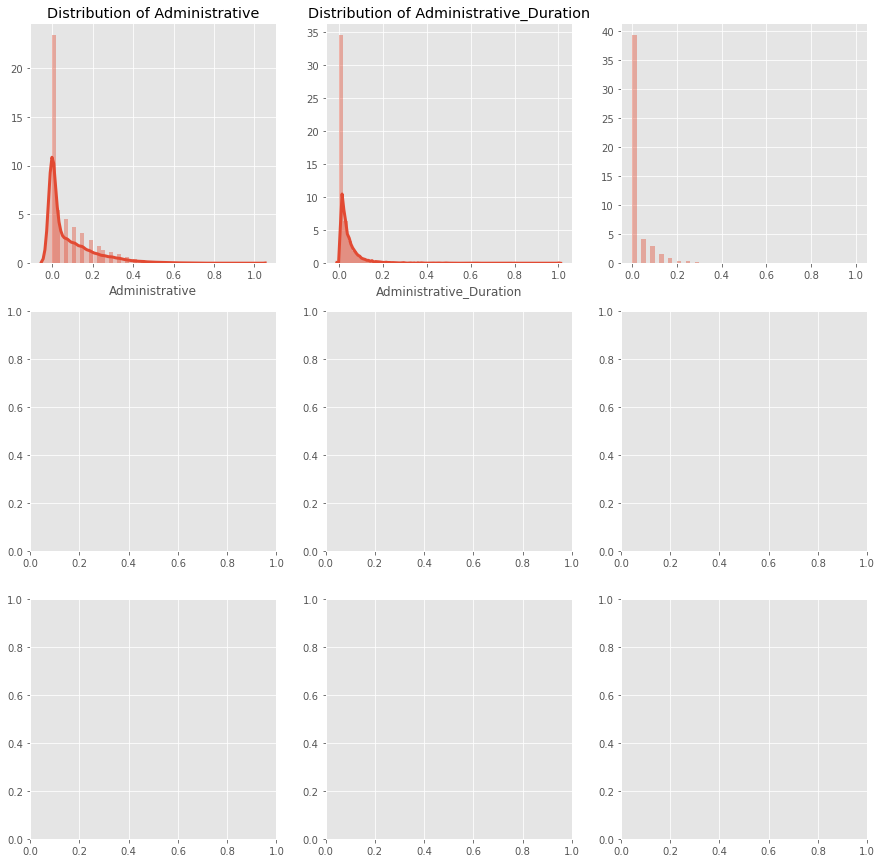

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(0, len(variables)):
    sns.distplot(data[variables[i]].dropna(), hist=True, kde=True, kde_kws={'shade': True, 'linewidth': 3},
                 ax=axes[i//3, i%3]).set_title(f'Distribution of {variables[i]}' )

plt.tight_layout();

### Kodowanie zmiennej 'Month'

Zmienną 'Month' zakodujemy w postaci kolejnych wierzchołków dwunastokąta foremnego, wpisanego w okrąg jednostkowy. W tym celu stworzymy dwie zmienne Month_x i Month_y, obie o zakresie wartości [-1, 1]. W ten sposób porządek między kolejnymi miesiącami zostanie zachowany (kąt), ale odległość między np. grudniem i styczniem będzie taka sama, jak między styczniem a lutym.

In [5]:
# najpierw kodowanie na int
month_to_int = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
data['Month'] = data['Month'].replace(month_to_int)

# nastepnie na okregu
data['Month_x']=data['Month'].transform(lambda x: np.sin((np.pi/6)*x))
data['Month_y']=data['Month'].transform(lambda x: np.cos((np.pi/6)*x))

Sprawdźmy jeszcze wizualnie poprawność metody.

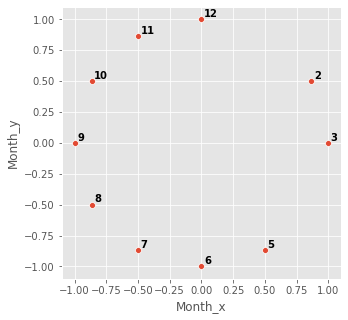

In [6]:
plot_data = data[['Month_x', 'Month_y', 'Month']].drop_duplicates().reset_index()
fig, ax = plt.subplots(figsize=(5, 5)) 
ax = sns.scatterplot('Month_x', 'Month_y', data=plot_data)

for i in range(0, plot_data.shape[0]):
    ax.text(plot_data.loc[i, 'Month_x']+0.02, plot_data.loc[i, 'Month_y']+0.02, 
    plot_data.loc[i, 'Month'], horizontalalignment='left', 
    size='medium', color='black', weight='semibold')

Miesiące poprawnie rozłożyły się na okręgu jednostkowym, co jest widoczne na powyższym wykresie. W danych brakuje obserwacji ze stycznia i kwietnia, zgodnie ze wcześniejszą analizą.

In [7]:
data = data.drop('Month', axis=1)

### Kodowanie zmiennych kategorycznych

Zajmiemy się teraz zmiennymi 'OperatingSystems', 'Browser', 'Region', 'TrafficType' i 'VisitorType'. Przyjrzyjmy się ponownie ich rozkładom.

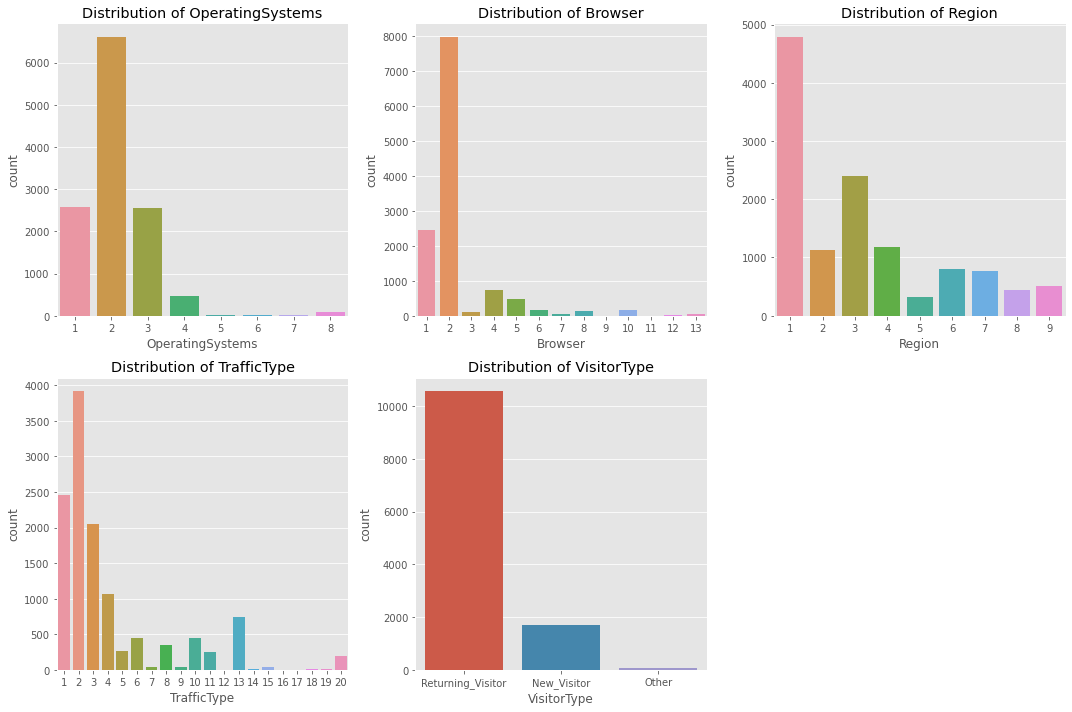

In [8]:
variables = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(0, len(variables)):
    sns.countplot(data=data, x=variables[i], ax=axes[i//3, i%3]).set_title('Distribution of %s' % (variables[i]))

    
fig.delaxes(axes.flatten()[5])
plt.tight_layout();

Posłużymy się kodowaniem One-Hot. Zmienna 'VisitorType' ma tylko 3 poziomy i może bezproblemowo zostać zakodowana w całości. Pozostałe zmienne są bardziej rozbudowane i kodowanie ich w całości znacząco zwiększyłoby wymiarowość danych. Z tego powodu zakodujemy tylko 4 najpowszechniejsze kategorie dla każdej ze wspomnianych zmiennych.

In [9]:
# kodowanie zmiennej VisitorType
encoder = OneHotEncoder(sparse=False)
temp = pd.DataFrame(encoder.fit_transform(data[['VisitorType']]))
temp.columns = encoder.get_feature_names(['VisitorType'])
data = pd.concat([data, temp], axis=1)
data = data.drop('VisitorType', axis=1)

# kodowanie pozostalych zmiennych
variables = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

for variable in variables:
    values_to_leave = data[variable].value_counts()[:4].index.tolist()
    data[variable] = data[variable].transform(lambda x: x if (x in values_to_leave) else 'other').astype(str)
    
    encoder = OneHotEncoder(sparse=False)
    temp = pd.DataFrame(encoder.fit_transform(data[[variable]]))
    temp.columns = encoder.get_feature_names([variable])
    data = pd.concat([data, temp], axis=1)
    data = data.drop(variable, axis=1)

Sprawdźmy efekt kodowania.

In [10]:
data.iloc[:, 14:]

,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_other,Browser_1,Browser_2,Browser_4,Browser_5,Browser_other,Region_1,Region_2,Region_3,Region_4,Region_other,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_other
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12326,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12327,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12328,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Kodowanie zmiennych typu Bool

Zmienne 'Weekend' i 'Revenue' przyjmują wartości 'True' i 'False', co przełożymy na wartości 1 i 0.

In [11]:
variables=  ['Weekend', 'Revenue']

for variable in variables:
    data[variable] = data[variable].transform(lambda x: 1 if x else 0)

Sprawdźmy efekt kodowania.


In [12]:
data[variables]

,Weekend,Revenue
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
12325,1,0
12326,1,0
12327,1,0
12328,0,0


### Efekt końcowy

Po przejściu przez powyższy proces dane prezentują się następująco.

In [13]:
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_x,Month_y,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_other,Browser_1,Browser_2,Browser_4,Browser_5,Browser_other,Region_1,Region_2,Region_3,Region_4,Region_other,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_other
0,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.002837,0.001000,0.000000,0.500000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.002837,0.000042,0.250000,0.700000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.000000,0.0,0.0,0.014184,0.009809,0.100000,0.250000,0.000000,0.0,1,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.111111,0.042663,0.0,0.0,0.075177,0.027883,0.035714,0.145153,0.033839,0.0,1,0,-2.449294e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12326,0.000000,0.000000,0.0,0.0,0.007092,0.007280,0.000000,0.106667,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12327,0.000000,0.000000,0.0,0.0,0.008511,0.002880,0.416667,0.433333,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12328,0.148148,0.022067,0.0,0.0,0.021277,0.005408,0.000000,0.105263,0.000000,0.0,0,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
data.to_csv("../data2.csv")

## Wstępne modelowanie

Funkcja _predict dokonuje klasteryzacji danych wybraną metodą i zwraca podział w postaci wektora.

In [14]:
def _predict(data, model):
    model.fit(data)
    if hasattr(model, 'labels_'):
        prediction = model.labels_.astype(np.int)
    else:
        prediction = model.predict(data)
    return prediction

In [18]:
data.iloc[0,:]

Administrative                   0.000000
Administrative_Duration          0.000000
Informational                    0.000000
Informational_Duration           0.000000
ProductRelated                   0.001418
ProductRelated_Duration          0.000000
BounceRates                      1.000000
ExitRates                        1.000000
PageValues                       0.000000
SpecialDay                       0.000000
Weekend                          0.000000
Revenue                          0.000000
Month_x                          0.866025
Month_y                          0.500000
VisitorType_New_Visitor          0.000000
VisitorType_Other                0.000000
VisitorType_Returning_Visitor    1.000000
OperatingSystems_1               1.000000
OperatingSystems_2               0.000000
OperatingSystems_3               0.000000
OperatingSystems_4               0.000000
OperatingSystems_other           0.000000
Browser_1                        1.000000
Browser_2                        0

In [16]:
mod = AgglomerativeClustering(n_clusters=6, linkage='ward')
pred = mod.fit_predict(data)

MemoryError: Unable to allocate 580. MiB for an array with shape (76008285,) and data type float64

Funkcja grouped_revenue dokonuje klasteryzacji danych (bez zmiennej 'Revenue') wybraną metodą i zwraca wykresy liczności grup oraz odsetków sesji zakończonych przychodem dla każdej grupy.

In [ ]:
def grouped_revenue(data, model):
    prediction = _predict(data.drop('Revenue', axis=1), model)
    plotdata = pd.DataFrame({'Group': prediction, 'Revenue': data['Revenue']})
    plotdata = pd.crosstab(plotdata['Group'], plotdata['Revenue'])
    plotdata['Cardinality'] = plotdata[0] + plotdata[1]
    plotdata['Revenue_ratio'] = plotdata[1] / plotdata['Cardinality']
    plotdata = plotdata.reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.barplot(data=plotdata, x='Group', y='Cardinality', ax=axes[0]).set_title('Cluster Cardinality');
    sns.barplot(data=plotdata, x='Group', y='Revenue_ratio', ax=axes[1]).set_title('In-cluster Revenue_ratio');
    
    plt.tight_layout(pad=1)
    
    return fig

Wywołamy teraz funkcję grouped_revenue dla przygotowanych wcześniej danych i modelu AgglomerativeClustering z parametrem linkage='ward' i róznymi wartościami parametru n_clusters (2-10).

In [ ]:
for i in range(2, 11):
    plot = grouped_revenue(data, AgglomerativeClustering(n_clusters=i, linkage='ward'))
    plot.suptitle(str(i)+' clusters', fontsize=20, y=1.05);

Ciekawym wynikiem jest np. ten uzyskany dla parametru n_clusters=6.

In [ ]:
plot = grouped_revenue(data, AgglomerativeClustering(n_clusters=6, linkage='ward'))
plt.close()
plot

Mamy tutaj 3 grupy o Revenue_ratio <= 0.10 i 3 grupy o Revenue_ratio >= 0.20, a zatem conajmniej dwukrotnie większym. Wszystkie grupy zawierają co najmniej 1000 obserwacji.

Spróbujemy teraz zidentyfikować znaczące czynniki, z punktu widzenia powyższego podziału.

W tym celu, przygotujemy model XGBoost do przewidywania zmiennej 'Revenue', a następnie odczytamy uzyskany w ten sposób Feature Importance (typu 'gain'). Następnie, porównamy rozkłady uzyskanych w ten sposób najważniejszych cech między grupami.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Revenue', axis=1), data['Revenue'], test_size=0.25, stratify=data['Revenue'])
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("Classification report:\n%s" %(classification_report(y_test, y_pred)))
print("AUC score: %.2f" % (roc_auc_score(y_test, y_pred)))

Wyniki modelu nie są idealne, ale w przypadku naszego zastosowania w zupełności wystarczające. Nie ma potrzeby np. strojenia hiperparametrów. Sprawdźmy, jakie Feature Importance uzyskaliśmy.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))  
with plt.style.context('ggplot'):
    plot_importance(xgb, ax=ax, importance_type='gain', show_values=False);

Porównamy rozkłady kilku najważniejszych cech (odczytanych z powyższego wykresu) między grupami. Na czerwono zaznaczono grupy o wysokim Revenue_ratio.

In [ ]:
ac = AgglomerativeClustering(n_clusters=6, linkage='ward')
pred = pd.Series(_predict(data.drop('Revenue', axis=1), ac), name='group')
grouped_data = pd.concat([data, pred], axis=1)

In [ ]:
# wezmy jeszcze weekend z racji wczesniejszej analizy tego zagadnienia (na etapie EDA)
variables=['PageValues', 'VisitorType_Returning_Visitor', 'Month_x', 'Month_y', 'BounceRates', 'SpecialDay', 'Administrative', 'Weekend']
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(0, len(variables)):
    sns.barplot(x='group', y=variables[i], data=grouped_data, estimator=np.mean, palette=['red', 'red', 'grey', 'red', 'grey', 'grey'],
                ax=axes[i//3, i%3]).set_title('%s mean by group' % (variables[i]))

fig.delaxes(axes.flatten()[8])
plt.tight_layout()

Z powyższych wykresów obserwujemy, że:
    
* dla grup o wyższym Revenue_ratio średnie PageValues jest zauważalnie wyższe,
* sesje nowych użytkowników zawierają się niemal wyłącznie w grupach o wyższym Revenue_ratio (grupa 1 to niemal same tego typu sesje),
* dla grup o wyższym Revenue_ratio średnie Month_x jest ujemne, a średnie Month_y dodatnie, a dla grup o niższym Revenue_ratio jest dokładnie odwrotnie,
* dla grup o wyższym Revenue_ratio średnie BounceRates jest niższe (szczególnie niskie jest dla grupy 1),
* zaskakująco, sesje z grup o wyższym Revenue_ratio, są znacznie oddalone od dni specjalnych (co jest zgodne ze wcześniejszą analizą),
* sesje z grup o wyższym Revenue_ratio zawierają średnio większą liczbę odwiedzonych stron administracyjnych,
* wśród sesji z grup o wyższym Revenue_ratio większy ich odsetek dotyczy weekendu (co jest zgodne ze wcześniejszą analizą).

Zestawimy jeszcze stwierdzenie 
> dla grup o wyższym Revenue_ratio średnie Month_x jest ujemne, a średnie Month_y dodatnie, a...

z poniższym wykresem, ilustrującym sposób, w jaki zakodowaliśmy informacje o miesiącach.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5)) 
ax = sns.scatterplot('Month_x', 'Month_y', data=plot_data)

for i in range(0, plot_data.shape[0]):
    ax.text(plot_data.loc[i, 'Month_x']+0.02, plot_data.loc[i, 'Month_y']+0.02, 
    plot_data.loc[i, 'Month'], horizontalalignment='left', 
    size='medium', color='black', weight='semibold')

Stwierdzenie to oznacza zatem, że sesje te dotyczą przede wszystkim IV kwartału.

### Dodatek
Poniżej znajdują się tabele z statystykami opisowymi wszystkich grup.

In [ ]:
for i in range(6):
    display(raw_data[grouped_data['group']==i].describe())